In [ ]:
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in toekn_index:
            token_index[word] = len(token_index) + 1
            
max_length = 10

results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))

for i, sample in enumerate(smaples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

In [9]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(
num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


/Users/jaisuk/.local/share/virtualenvs/study-XD92VzB6/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 49us/step - loss: 0.6712 - acc: 0.6173 - val_loss: 0.6193 - val_acc: 0.6970
Epoch 2/10
20000/20000 [==============================] - 1s 49us/step - loss: 0.5417 - acc: 0.7509 - val_loss: 0.5218 - val_acc: 0.7348
Epoch 3/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.4601 - acc: 0.7875 - val_loss: 0.4973 - val_acc: 0.7458
Epoch 4/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.4214 - acc: 0.8078 - val_loss: 0.4933 - val_acc: 0.7552
Epoch 5/10
20000/20000 [==============================] - 1s 39us/step - loss: 0.3950 - acc: 0.8241 - val_loss: 0.4924 - val_acc: 0.7576
Epoch 6/10
20000/20000 [==============================] - 1s 39us/step - loss: 0.3726 - acc: 0.8353 - val_loss: 0.4978 - val_acc: 0.7564
Epoch 7/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.3537 - acc: 0.8448 - val_loss: 0.5018 - val_acc:

In [13]:
import os

data_dir = '../../datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f=open(fname)
data =f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [14]:
import numpy as np

float_data = np.zeros((len(lines), len(header) -1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

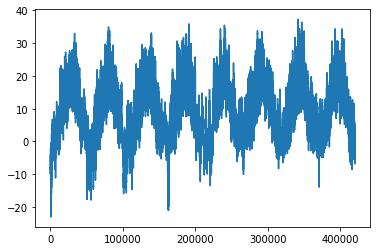

In [16]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

In [17]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# 정규분포 정규화를 이용 => mean=0, std=1

In [23]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [24]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = 200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                   lookback = lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step,
                   batch_size=batch_size)
test_gen = generator(float_data,
                   lookback = lookback,
                   delay=delay,
                   min_index=300001,
                   max_index=None,
                   step=step,
                   batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch = 500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 27ms/step - loss: 1.1974 - val_loss: 0.7300
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.4090 - val_loss: 0.2485
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2871 - val_loss: 0.2728
Epoch 4/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2665 - val_loss: 0.2779
Epoch 5/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2526 - val_loss: 0.3781
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2456 - val_loss: 0.4474
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2379 - val_loss: 0.2629
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2328 - val_loss: 0.2168
Epoch 9/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2280 - val_loss: 0.3355
Epoch 10/20
500/500 [==============================] - 14s 29ms/step - loss: 0.222

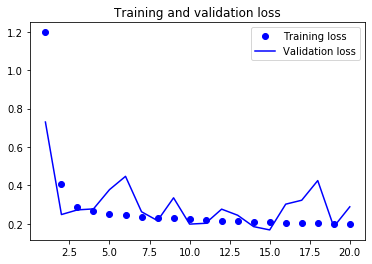

In [26]:
import matplotlib.pyplot as plt

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

이후는 CPU 터질거 같아서... 여기까지... 

결국... 고려해야 할 것


- 책 7.3절 인용


    단어 임베딩 -> 의미있는 조합의 input을 통해 효과적인 벡터화가 성공을 결정한다.

    배치 정규화 (혹은 배치 재정규화..) 이는 리서치 필요

    깊이별 분리 합성곱

    RNN (LSTM, GRU, 양방향)

    CNN(1D, 2D)

    하이퍼 파라미터 최적화...
    
    모델 앙상블